### ASTR-324, University of Washington


# Week 6: Sampling and Markov chain Monte Carlo

##### Bibliography:

- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 5
- [Gordon Richard's notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Additional reading:
- [Richard McElreath: "Statistical Rethinking" (UW libraries link)](https://na01.alma.exlibrisgroup.com/view/action/uresolver.do?operation=resolveService&package_service_id=79875191470001452&institutionId=1452&customerId=1450) Chapter 8, especially the story of Good King Markov -
[this open source repository](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_08.ipynb) has the Python/pymc3 "translation" of the code
- [Jake Tai: "An Introduction to Markov Chain Monte Carlo"](https://jaketae.github.io/study/MCMC/)
- [Thomas Wiecki: "MCMC sampling for dummies"](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)
  
##### For those who want to dive deep:
- [Andrieu et al. "An Introduction to MCMC for Machine Learning"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf) (includes a few pages of history)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, integrate
from scipy.stats import norm, cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev

##  Markov Chain Monte Carlo

### Motivation

Consider the problem of estimating location and scale parameters
for a sample drawn from Gaussian distribution that we introduced earlier.
We had a two-dimensional posterior pdf for $\mu$ and $\sigma$: (This is figure 5.4 from the textbook.)

![BayesSlide1](figures/Lgauss.jpg)

We obtained the marginalized pdfs by intergrating the two-dimensional
posterior over the other variable.

It was easy to numerically integrate the posterior pdf, as well 
as to find its maximum, using brute force grid search because
it was only a two-dimensional problem. With 100 grid points per
coordinate it was only $10^4$ values. However, even in a case
of rather simple 5-dimensional problem (as we'll discuss later 
today), we'd have $10^{10}$ values! And often we work with models 
of much higer dimensionality (it can be thousands!).

We need something better.

### Definition of the general problem

Many quantities of interest in Bayesian inference are multi-dimensional integrals involving the posterior $p(\theta | D,I)$ (recall that $\theta$ is a multi-dimensional vector). For example:

1) **Marginalization**: if the first $P$ elements of $\theta$ are the parameters of interest, and the next $k-P$ parameters are nuisance parameters, marginalizing over the nuisance parameters means integrating over the nuisance parameters:

$$p(\theta_1, \ldots, \theta_{P} \mid D,I) = \int p(\theta \mid D,I) \, d\theta_{P+1} \ldots d\theta_{k}$$

For example, in our model describing measurements as being drawn from a Gaussian with mean $\mu$ and standard deviation $\sigma$, we may be most interested in $\mu$. To marginalize over the nuisance parameter $\sigma$ to get a probability distribution over $\mu$ alone, we would evaluate:

$$p(\mu \mid D,I) = \int p(\mu,\sigma \mid D,I) \, d\sigma$$

2) **Point estimates**: if we want the mean value of one parameter $\theta_m$, then we evaluate this integral over all model parameters:

$$\hat{\theta}_m = \int \theta_m \, p(\theta \mid D,I) \, d\theta$$

For example, in our model describing measurements as being drawn from a Gaussian with mean $\mu$, the mean value of $\mu$ is:

$$\hat{\mu} = \int \mu \, p(\mu,\sigma \mid D,I) \, d\mu d\sigma$$

3) **Credible regions**: we can also finding a credible region that contains a fraction $\alpha$ of the probability in the posterior by finding a region $R$ where:

$$\alpha = \int_{R} p(\theta \mid D,I) d\theta$$

For example, in our model describing measurements as being drawn from a Gaussian with mean $\mu$ and standard deviation $\sigma$, we can find a 95% credible interval for $\mu$ by finding $\mu_{lower}$ and $\mu_{upper}$ such that:

$$0.95 = \int_{\mu_{lower}}^{\mu_{upper}} p(\mu, \sigma \mid D,I) \, d\mu d\sigma$$

In [2]:
def plotfun(f, xmin=0, xmax=1, npts=1000):
    x = np.linspace(xmin, xmax, npts)
    plt.figure(figsize=(14, 8))
    plt.plot(x, f(x))

## Towards Efficient Integration Techniques

Let's consider how we can do integrals on a one dimensional posterior. As a concrete example, let's say we want to measure the fraction of the time a coin comes up tails, and we call this fraction $x$. If we use the Jeffrey's prior and use the likelihood to calculate the posterior on $x$, we will get the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution):

$$ p(x \mid \alpha, \beta) = \frac{x^{\alpha-1} (1-x)^{\beta-1}}{B(\alpha,\beta)} $$

Let's say after a few coin flips, our posterior is the Beta distribution with $\alpha=3.5$ and $\beta=1.5$.

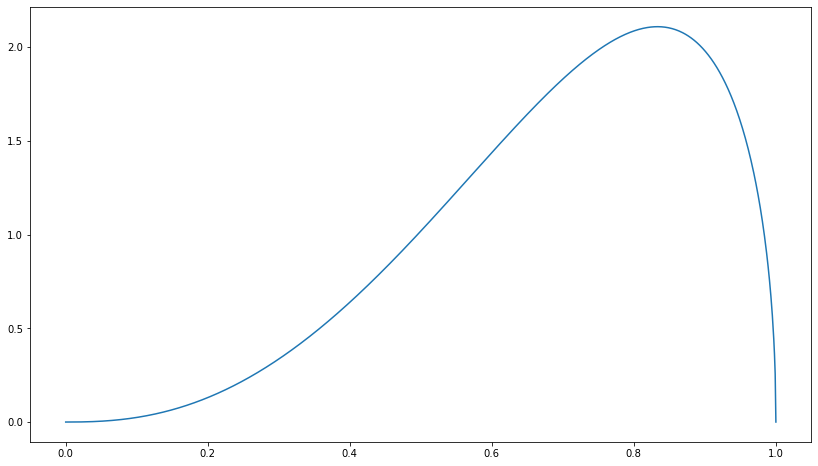

In [3]:
from scipy.stats import beta
betapost = beta(3.5, 1.5)
plotfun(betapost.pdf)

## Integration: Analytic

Analytically integrating the Laplace distribution function gives us the regularized incomplete beta function $I_x(\alpha,\beta)$ (which `scipy` knows how to evaluate):

$$
{\rm CDF}(x) = \int_0^x p(x' \mid \alpha,\beta) \, dx' = \int_0^x \frac{x'^{\alpha-1} (1-x')^{\beta-1}}{B(\alpha,\beta)} dx' \equiv I_x(\alpha, \beta)
$$

and now we can compute any definite integral as:

$$
\int_{x_{min}}^{x_{max}} p(x'\mid \alpha,\beta) \, dx' = {\rm CDF}(x_{max}) - {\rm CDF}(x_{min})
$$

Let's compute the integral between $(0.4, 0.6)$:

In [4]:
betapost.cdf(0.6) - betapost.cdf(0.4)

0.205035350427541

## Integration: Numerical

We can also integrate this function numerically using the [rectangle rule](https://en.wikipedia.org/wiki/Riemann_sum):

$$
\{ x_j \} = \{ x_0 + 0.5 \Delta x, x_0 + 1.5 \Delta x, ... , x_0 + (N-0.5) \Delta x \}
$$

$$
\int_{x_{min}}^{x_{max}} p(x') dx' \approx  \sum_{j=1}^N p(x_j) \, \Delta x = \Delta x \, \sum_{j=1}^N p(x_j).
$$

where $\{ x_j \}$ are a series of values evenly spread over the $(x_{min}, x_{max})$ integration interval, spaced $\Delta x$ apart.

We approximate the area under the $p(x)$ curve by a series of $\Delta x$-wide rectangles whose areas we sum. The narrower the rectangles, the better the approximation.

0.205023142394758


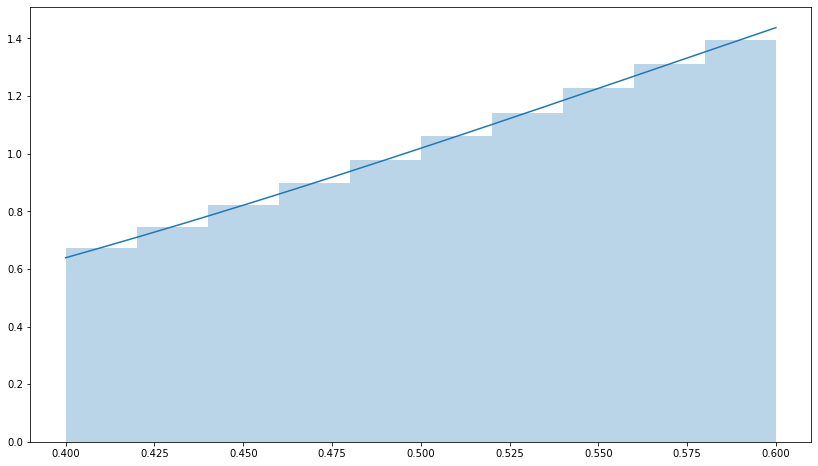

In [5]:
# try changing dx and observe how the precision changes
xmin, xmax, dx = 0.4, 0.6, 0.02
x = np.arange(xmin+0.5*dx, xmax, dx)
y = betapost.pdf(x)

plotfun(betapost.pdf, xmin, xmax)
plt.gca().bar(x, y, align='center', width=dx, alpha=0.3);

print(np.sum(y*dx))

## Integration: Sampling

Note how the rectangles from the Riemann sum of $p(x)$ are very reminiscent of histograms of samples drawn from $p(x)$ (with appropriate normalization). We could construct them from a sample!

If we look at our integral again:
$$\int_{x_{min}}^{x_{max}} p(x') dx' \approx  \sum_{j=1}^N p(x_j) \Delta x$$
we can see that $p(x_j) \Delta x$ is the probability that a sample will fall into bin $j$.

So if we have $M$ samples from $p(x)$, we expect that $M p(x_j) \Delta x$ of them will fall into bin $j$. Thus, if $M_j$ of our samples fall into bin $j$, we can approximate:
$$M_j \approx M p(x_j) \Delta x \Rightarrow p(x_j) \Delta x \approx \frac{M_j}{M}$$
which gives us for our integral:
$$\int_{x_{min}}^{x_{max}} p(x') dx' \approx  \sum_{j=1}^N \frac{M_j}{M}$$


The sum $\sum_{j=1}^{N} M_j$ is just the number of samples that fall in all bins between $x_{min}$ and $x_{max}$. Let's define this number of samples as $M_{in}$. Then our integral is simply:
$$\int_{x_{min}}^{x_{max}} p(x') dx' \approx \frac{M_{in}}{M}$$

In [6]:
np.random.seed(42)

N = 10000
xi = betapost.rvs(size=N)

xmin, xmax, dx = 0.4, 0.6, 0.02
inside = (xmin <= xi) & (xi <= xmax)
np.sum(inside) / N

0.1989

That seems to work reasonably well, and it was super easy to calculate! We can think of this sum as an average, where each sample either has a value of 1 if it's inside or 0 if it's outside. We can then appeal to the Central Limit Theorem to see how much error our approximation to the integral will have:

In [7]:
print('%0.4f' % (np.std(inside, ddof=1) / np.sqrt(N)))

0.0040


**Conclusion: if we have a sample drawn from a function, we can numerically approximate any integral of that function with a simple ratio of the number of samples that fell within the integration boundaries, vs. the total number of samples drawn!**:

$$
I \approx \frac{N({\rm within \, bounds)}}{N}
$$

This is true for arbitrarily complex functions, as well as multivariate functions.

## Integration: Computing Expected Values

What if we want to find the mean value of x? If we use the rectangle rule,
$$\hat{x} = \int_0^1 x' p(x') dx' \approx \sum_{j=1}^N x_j p(x_j) \Delta x$$

Again, if we have a sample from $p(x)$, we can approximate $M p(x_j) \Delta x \approx M_j$ where $M_j$ is the number of samples in bin $j$.
$$\hat{x} \approx \sum_{j=1}^N \frac{x_j M_j}{M}$$

Imagine making the bins so thin that each bin either has zero samples or one sample (because $x$ is continuous, it is vanishingly unlikely that two samples will have the exact same value of $x$). Then $M_j=0,1$ for each bin, and the bins with $M_j=0$ disappear from the sum:
$$\hat{x} \approx \frac{1}{M} \sum_{j \, \ni \, M_j = 1} x_j$$

The bins are so thin that the value at the middle of the bin, $x_j$, is almost the same as the value of the sample inside it. This sum has $M$ terms because each sample is in a bin and each bin in the sum has exactly one sample. So we can replace the sum over bins with a sum over samples:
$$\hat{x} \approx \frac{1}{M} \sum_{i=1}^M x_i$$

Which is just the mean value of $x$ in our sample!

In [8]:
print('%0.4f' % np.mean(xi))

0.7045


And again, we can appeal to the Central Limit Theorem to estimate the error that our approximation introduces:

In [9]:
print('%0.4f' % (np.std(xi, ddof=1) / np.sqrt(N)))

0.0018


Let's compare with the mean that `scipy` knows how to calculate:

In [10]:
betapost.mean()

0.7

**Conclusion: if we have a sample drawn from a function $p(x)$, we can numerically approximate any integral $\int g(x) p(x) dx$ by averaging $g(x)$ over the samples.**

This approximation will get better the more samples we have:

In [11]:
np.random.seed(42)

I0 = betapost.mean()   # true value 
for N in [10, 100, 1000, 10000, 100000]:
    xi = betapost.rvs(N)
    I = np.mean(xi)
    std = np.std(xi, ddof=1)/np.sqrt(N)
    err = (I-I0)/I0
    print(f'N: {N:6},   I:{I: .5f} +/- {std: .5f},   err: {100*err: .3f}%')

N:     10,   I: 0.75004 +/-  0.04618,   err:  7.149%
N:    100,   I: 0.70011 +/-  0.01703,   err:  0.016%
N:   1000,   I: 0.70081 +/-  0.00570,   err:  0.116%
N:  10000,   I: 0.70573 +/-  0.00184,   err:  0.818%
N: 100000,   I: 0.70003 +/-  0.00059,   err:  0.004%


This is excellent!

It means that, given a sample, we can very easily (approximately) compute any integral of the form above, if we just have a sample drawn from $p(x)$!

This is an example of **Monte Carlo integration**.

## Monte Carlo Methods
 

![monaco](figures/monacoMap.jpg)
![monaco](figures/montecarlophoto.jpg)

Monte Carlo is a city in Europe, in the Principality of Monaco
and they are known for gambling. A family of random sampling methods was named
after Monte Carlo in order to keep the method secret [\*] (because it was invented and
used for nuclear weapons design in the U.S. after World War II). With 
the advent of computers, Monte Carlo methods, such as Monte Carlo integration and 
Monte Carlo statistical tests, became hugely important. 

[\*] Note: this is an _awful_ codename. Leaks information.

The modern version of the Markov Chain Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. The name Monte Carlo
was given to the method by Nick Metropolis, who then invented the Metropolis sampler, which evolved into
one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm. 

Algorithms for generating Markov chains are numerous and greatly vary in complexity
and applicability. Many of the most important ideas were generated in physics, especially
in the context of statistical mechanics, thermodynamics, and quantum field theory.

## Advantages

Solving integrals of the form:

$$ I = \int_V g(\theta) \, p(\theta) \, d\theta,$$

via sampling has two key advantages over grid-based methods (i.e., the rectangle rule):

1. The number of grid points on which we'd have to compute $p(\theta)$ and $g(\theta)$ explodes as the number of dimensions (i.e., the number of variables) grows. Sampling is *much* less sensitive to this. We can approximate even million-dimensional integrals!

2. Unless you already know something about $p(\theta)$, grid integration may spend much of its time in areas where the integrand is close to zero and doesn't contribute much to the integral. Integrating by sampling from $p(x)$ avoids this, making the computation much more efficient.

## Example

In [12]:
def twoD_gauss_with_grid():
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib.patches import Ellipse
    from astroML.stats.random import bivariate_normal

    mean = np.array([0, 0])
    sigma_1 = 2
    sigma_2 = 1
    alpha = np.pi / 4

    #------------------------------------------------------------
    # Draw 10^5 points from a multivariate normal distribution
    #
    np.random.seed(0)
    x, cov = bivariate_normal(mean, sigma_1, sigma_2, alpha, size=100_000,
                              return_cov=True)

    sigma_x = np.sqrt(cov[0, 0])
    sigma_y = np.sqrt(cov[1, 1])
    sigma_xy = cov[0, 1]

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # plot a 2D histogram/hess diagram of the points
    H, bins = np.histogramdd(x, bins=2 * [np.linspace(-9, 9, 101)])
    ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
              extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])

    # draw 1, 2, 3-sigma ellipses over the distribution
    for N in (1, 2, 3):
        ax.add_patch(Ellipse(mean, N * sigma_1, N * sigma_2,
                             angle=alpha * 180. / np.pi, lw=1,
                             ec='k', fc='none'))

    kwargs = dict(ha='left', va='top', transform=ax.transAxes)

    ax.text(0.02, 0.98, r"$\sigma_1 = %i$" % sigma_1, **kwargs)
    ax.text(0.02, 0.93, r"$\sigma_2 = %i$" % sigma_2, **kwargs)
    ax.text(0.02, 0.88, r"$\alpha = \pi / %i$" % (np.pi / alpha), **kwargs)

    ax.text(0.15, 0.98, r"$\sigma_x = %.2f$" % sigma_x, **kwargs)
    ax.text(0.15, 0.93, r"$\sigma_y = %.2f$" % sigma_y, **kwargs)
    ax.text(0.15, 0.88, r"$\sigma_{xy} = %.2f$" % sigma_xy, **kwargs)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base = float(bins[0][1]-bins[0][0]))
    plt.gca().xaxis.set_minor_locator(loc)
    plt.gca().yaxis.set_minor_locator(loc)

    plt.grid(b=True, which='minor')

    plt.show()

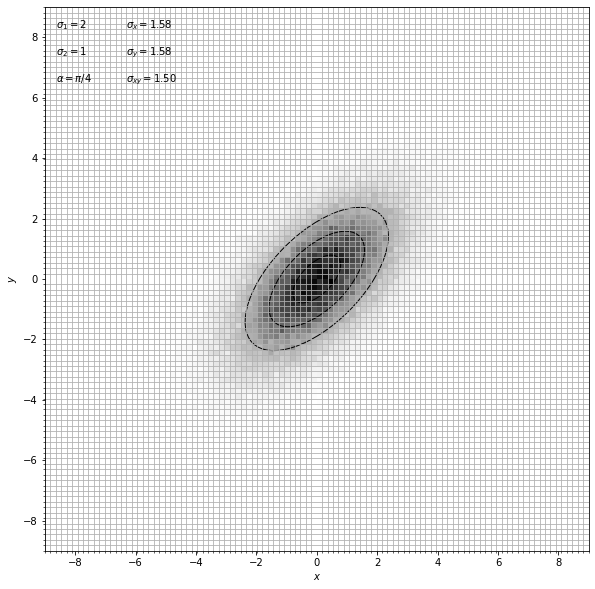

In [13]:
twoD_gauss_with_grid()

The image above has the same number of samples (which were binned and visualized as the image) and grid points.

Notice how nearly all of the grid points are outside of the area where $p(x)$ is appreciably different from zero. If we computed an integral, less than $\sim 10\%$ of points would cover the area that actually contributes appreciably to the sum.

Contrast this to sampling from $p(x)$, where nearly all samples are concentrated in the area where the value of $p(x)$ is relatively high (close to the center). This makes computing the integral from these points over 10x more more efficient (more accurate for the same amount of work) than doing it on a grid!

This difference becomes even more drammatic as the dimensionality of the problem grows (e.g., imagine what this would look like in 3D, 4D, etc...).

## Representing posteriors with samples

Remember that a posterior is some (potentially highly-dimensional) function:

$$
p(\theta|D) \propto p(D|\theta) p(\theta)
$$

In specific cases it can be written down analytically (e.g, the 2D gaussian above), but in the general case it can't and we'd have to tabulate it's values on a (large) grid.

The ability to compute integrals from samples gives us another, more efficient, way of recording the posterior: **instead of tabulating on a (potentially extremely large) grid, sample it and write down that sample.**

This sample can then be used to compute all integrals of interest. It can also be histogrammed when we want to visualize the posterior (the prior 2D Gaussian plot is an example of that). **For practical purposes, it *is* our posterior.**

## Technical problem: Normalizing the Posterior

Excellent! So how do we draw a sample from an (arbitrary) posterior?

This is where we encounter a technical problem. We obtain posteriors by the application of the Bayes rule. And while it's easy to compute a function **proportional** to the posterior:

$$
p(\theta|D) \propto p(D|\theta) p(\theta)
$$

, its normalization constant (the integral) is generally unknown.

While we haven't discussed it, most algorithms that draw samples from some $p(x)$ rely on the knowledge of the integral of $p(x)$ to do so. That's how the various `.rvs` functions in `scipy` are implemented.

So we have a chicken-and-an-egg problem:
  * To draw samples from the unnormalized $p(x)$ with common algorithms, we need to know its integral.
  * To efficiently compute the integral of the unnormalized $p(x)$, we need to draw samples from it!

Question: Are there methods that can draw samples from some $p(x)$, but which will not require the knowledge of the integral of $p(x)$?

##  Markov Chains

Yes. A family of sampling procedures known as ***Markov chain Monte Carlo*** allows us to do this.

A **Markov chain** is a sequence of random variables where a given value directly depends only on its preceding value. That is, imagine I draw samples one by one. If I've just drawn a value $\theta_{i}$, the probability to draw some $\theta_{i+1}$ will only explicitly depend on $\theta_{i}$, my current value, and not on any prior values. I.e., I don't have memory of the past; decisions are based solely on where I am in the present. A random walk (Brownian motion) is an example of a Markov process.

Here's a simple Markov chain approximating December in Seattle. Assume weather can only be sunny or rainy. If today is rainy, there is a 63% chance that tomorrow will be sunny and a 37% chance that tomorrow will also be rainy. If today is sunny, tomorrow will always be rainy. (Weather doesn't actually work like this - the weather tomorrow probably depends on the weather from the past few days, not just yesterday.)

<img src="figures/weatherMC.png" width="400">

As we run this Markov chain longer and longer, its values will asymptotically approach a **stationary distribution**. That is, the values in the chain will start to look like samples from the stationary distribution.

In our weather Markov chain, the weather alternates between single sunny days and streaks of rainy days. The rainy streaks will last, on average, $\frac{1}{0.63} = 1.59 $ days. Thus, the stationary distribution has 1.59 rainy days for every 1 sunny day, or $\frac{1.59}{1+1.59}=61.35\%$ rainy days.

In [14]:
np.random.seed(1337)

ndays = 10000
rainchain = np.empty(ndays, dtype=np.int) # store whether it was rainy that day
rainy = True # arbitrarily start the chain on a rainy day

for i in range(ndays):
    if rainy: # if rainy, 63% chance of sunny next, otherwise still rainy
        if np.random.uniform() < 0.63:
            rainy = False
    else: # if sunny, 100% chance of rainy next
        rainy = True
    # store the weather
    rainchain[i] = rainy

print('First 31 days of Markov chain:', rainchain[:31])
print('Fraction of rainy days: %0.2f%% +/- %0.2f%%' % (100*np.mean(rainchain), 100*np.std(rainchain, ddof=1) / np.sqrt(ndays)))

First 31 days of Markov chain: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1]
Fraction of rainy days: 61.85% +/- 0.49%


If we can make a Markov chain whose stationary distribution is our posterior distribution, we can use the Markov chain to generate samples from the posterior distribution. Importantly, we can use this technique to **generate samples from distributions whose integral/normalization is unknown.** Given a function proportional to $p(\theta)$, MCMC returns a sample of points, or **"chain"**, from the k-dimensional parameter space, with  a distribution that is **asymptotically proportional** to $p(\theta)$.

## MCMC at a High Level: Walkers

Algorithms for generating Markov chains are numerous and greatly vary in complexity and applicability. **We will only describe them here at a very high level, and mostly focus on their usage via Python libraries.**

Most MCMC algorithms have in common the concept of a **walker** -- an imaginary entity moving through the space that's being sampled. The walker starts at some random point of the parameter space. Its motion occurs as a sequence of steps, and the set of positions where the walker is at each step forms the sample -- the **Markov chain**.

What are the rules of motion? At each step $i$, the walker is at $\theta_i$, chooses a potential new spot to move to $\theta_{i+1}^{proposed}$, and decides whether to move there based on the **transition probability**:

$$ T(\theta_{i+1}^{proposed}|\theta_i) $$

$T(\theta_{i+1}^{proposed}|\theta_i)$ is also called the **jump kernel** or **transition kernel**. Various MCMC algorithms mainly differ in their choice of transition kernel.

##  Markov Chain Monte Carlo

**The Metropolis-Hastings algorithm** adopts the kernel

$$  T(\theta_{i+1}\,|\,\theta_i) =  p_{\rm acc}(\theta_i,\theta_{i+1}) \, K(\theta_{i+1}\,|\,\theta_i), $$

where the **proposal distribution** $K(\theta_{i+1}\,|\,\theta_i)$ is an *arbitrary* function that specifies how big of a step a walker can make. A Gaussian distribution centered on $\theta_i$ is often used for $K(\theta_{i+1}|\theta_i)$.

The proposed point $\theta_{i+1}$ is then randomly accepted with the acceptance probability:

$$   p_{\rm acc}(\theta_i,\theta_{i+1}) = { K(\theta_i\,|\,\theta_{i+1})\over
                       K(\theta_{i+1}\,|\,\theta_i)} {p(\theta_{i+1}) \over p(\theta_i)}$$

(when exceeding 1, the proposed point $\theta_{i+1}$ is always accepted). **When $\theta_{i+1}$ is rejected, $\theta_i$ is added to the chain instead.** Often, the proposal distribution is symmetric with $K(\theta_{i+1}\mid\theta_i) = K(\theta_i\mid\theta_{i+1})$, so the first term cancels out, giving the **Metropolis** algorithm. To get this acceptance probability right, we only need a function proportional to the posterior $p(\theta)$ - any normalization constant will cancel out.

Why does this Markov chain have a stationary distribution proportional to $p(\theta)$? It has detailed balance (a sufficient but not necessary condition):
$$p(\theta_i) \, T(\theta_{i+1}\mid\theta_i) = p(\theta_{i+1}) \, T(\theta_i \mid \theta_{i+1})$$

Imagine having a large collection of walkers that start out distributed proportional to $p(\theta)$. Then the left hand side is the fraction of walkers that started at $\theta_i$ and will leave it to go to $\theta_{i+1}$, while the right hand side is the fraction of walkers that started at $\theta_{i+1}$ and will leave it to go to $\theta_i$. These two sides are equal for every combination of $\theta_i,\theta_{i+1}$, so the walkers stay distributed proportional to $p(\theta)$. Thus, $p(\theta)$ is the stationary distribution of the Markov chain.

<img src="figures/weatherMC.png" width="400">

In our weather Markov chain, imagine we have 10000 walkers where 6135 walkers start with rainy days and 3865 walkers start with sunny days. All of the 3865 walkers with sunny days will have rainy days tomorrow, so 3865 walkers will "leave" the sunny state for the rainy state. However, 63% of the 6135 rainy day walkers will have sunny days tomorrow, so 6135 $\times$ 0.63 = 3865 walkers will "leave" the rainy state for the sunny state. Thus, 61.35% rainy days is the stationary distribution.

##  Markov Chain Monte Carlo

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1) given $\theta_i$ and $K(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ The scale of $K(\theta_{i+1}|\theta_i)$ defines how big of a jump the walker could make.

2) compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.

3) draw a random number between 0 and 1 from a uniform distribution; if it smaller than
   $p_{\rm acc}(\theta_i,\theta_{i+1})$ we accept $\theta_{i+1}$.
   
4) if $\theta_{i+1}$ is accepted, add it to the chain. If not, add $\theta_{i}$ (again) to the chain.

After many of these steps, our chain will form a sample from the distribution $p(\theta)$!

### Metropolis-Hastings Example

Let's get samples from the Beta distribution posterior we used earlier:
$$ p(x \mid \alpha, \beta) = \frac{x^{\alpha-1} (1-x)^{\beta-1}}{B(\alpha,\beta)} $$
with $\alpha=3.5$ and $\beta=1.5$.

This posterior is properly normalized: let's pretend we don't know the normalization and only know:
$$ p(x \mid \alpha, \beta) \propto x^{\alpha-1} (1-x)^{\beta-1} $$

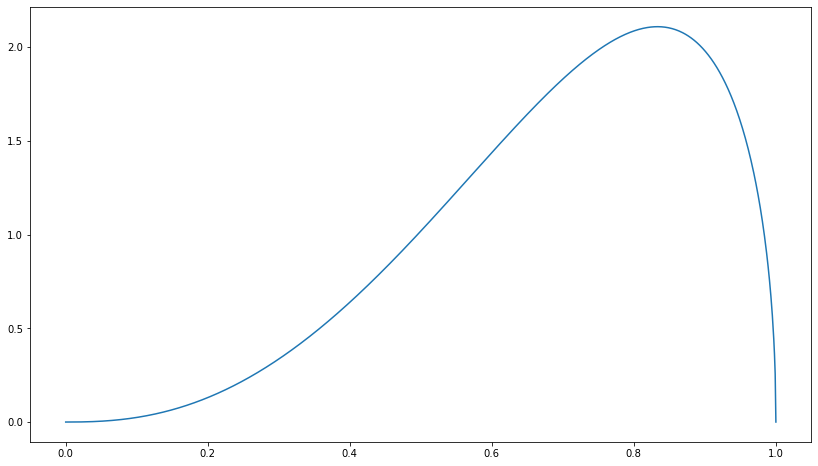

In [15]:
plotfun(betapost.pdf)

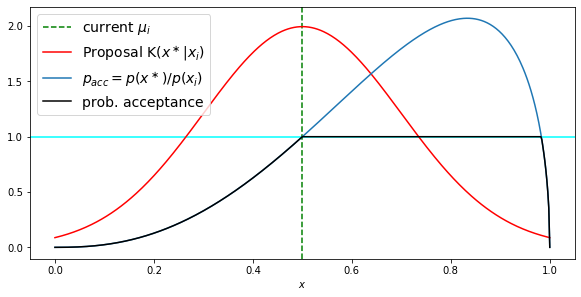

NOTE: we accept if a uniform random number (0-1) falls below the black dotted curve.


In [16]:
#define posterior
alpha = 3.5
beta = 1.5
def myPosterior(x, alpha, beta):
    if x >= 0 and x <= 1: # x must be between zero and one
        return x**(alpha-1) * (1-x)**(beta-1)
    else:
        return 0

xGrid = np.linspace(0, 1, 500)
posterior = np.zeros_like(xGrid)

for j in range(0,np.size(xGrid)):
    posterior[j] = myPosterior(xGrid[j], alpha, beta)

## illustrate Metropolis-Hastings algorithm 
xStart = 0.5
posteriorStart = myPosterior(xStart, alpha, beta)
pRatio = posterior/posteriorStart

# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)
ax0 = fig.add_subplot(111)
plt.xlabel('$x$')
plt.axhline(1, ls='-', c='cyan')
plt.axvline(xStart, ls='--', c='green', label=r'current $\mu_i$')

# plot proposal distribution
sigmaProp = 0.2
prop = norm(xStart, sigmaProp).pdf(xGrid)
plt.plot(xGrid, prop, c='red', label=r'Proposal K($x^\ast|x_{i}$)')
plt.plot(xGrid, pRatio, label=r'$p_{acc}=p(x^\ast)/p(x_i)$')
pRatio[pRatio > 1] = 1
plt.plot(xGrid, pRatio, c='black',label=r'prob. acceptance')
ax0.legend(loc=2, prop=dict(size=14))
plt.show() 

print('NOTE: we accept if a uniform random number (0-1) falls below the black dotted curve.')

In [17]:
## generate a chain using Metropolis-Hastings algorithm 
np.random.seed(324)
# Markov chain 
M = 5000  # the requested number of steps in the chain
chain = np.empty(M)
chain[0] = 0.5 # starting position
Pold = myPosterior(chain[0], alpha, beta)

# gaussian width for "jumping" from the current position
sigmaProp = 0.20       

Na = Nr = Np = 0
# and now sample M times
for i in range(1,M):
    # 1) generate a new value: a gaussian jump from current value
    Cold = chain[i-1]
    Cnew = stats.norm(Cold, sigmaProp).rvs(1)
    Pnew = myPosterior(Cnew, alpha, beta)
    # 2) acceptance condition 
    Pratio = Pnew / Pold  
    if (Pratio > 1): 
        Np += 1   # just a counter, nothing else is done 
    # if we only accept Pratio>1, we'll get a hill-climbing algorithm
    # instead, we'll randomly accept this proposal with probability Pratio 
    randNumber = stats.uniform(0, 1).rvs(1)
    if (randNumber < Pratio):
        # accepting this new proposed value
        chain[i] = Cnew
        Pold = Pnew
        Na += 1
    else:
        # rejecting the proposed value and stickin' with the previous one 
        chain[i] = Cold
        Nr += 1
 
print('NNN(arp): ', Na, Nr, Np)

NNN(arp):  3356 1643 1673


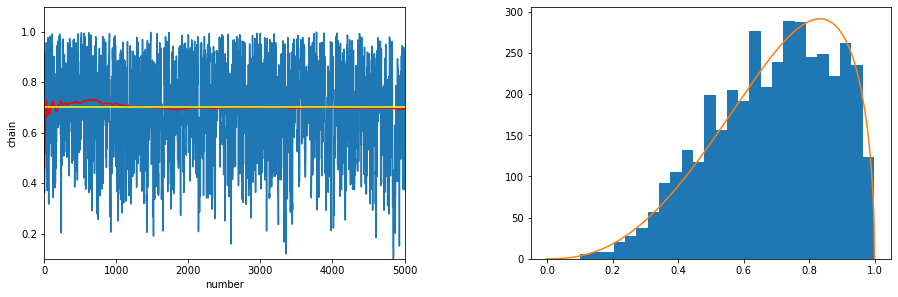

In [18]:
# start plot 
fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

ax1 = fig.add_subplot(121)
x = np.linspace(1,M,M)
plt.plot(x, chain)
ax1.axis([0, M, np.min(chain), 1.1*np.max(chain)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chain[:int(N)]) for N in x]
ax1.plot(x, meanC,c='red') 

ax1.axhline(betapost.mean(), c='yellow')

ax2 = fig.add_subplot(122)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chain[x>Nburn])
Nhist, bins, patches = plt.hist(chain[x>Nburn], bins = 'fd', histtype = 'stepfilled')
ax2.plot(xGrid, betapost.pdf(xGrid) * Nchain * (bins[1]-bins[0]))

plt.show()

To see Markov chain Monte Carlo in action, check out See Chi Feng's [MCMC Interactive Gallery](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana).

## Caveats

* Adjacent samples are correlated (not independent)! We'll see this when we go through a couple of examples.

* Although $K(\theta_{i+1}|\theta_i)$ satisfies a Markov chain requirement that it
must be a function of only the current position $\theta_i$, it takes a number
of steps to reach a stationary distribution from an initial arbitrary position $\theta_0$. **These early steps are called the "burn-in" and need to be discarded in analysis.**
There is no general theory for finding transition from the burn-in phase to
the stationary phase; several methods are used in practice. Gelman and Rubin
proposed to generate a number of chains and then compare the ratio of
the variance between the chains to the mean variance within the chains (this
ratio is known as the $R$ statistic). For stationary chains, this ratio will
be close to 1.

When the posterior pdf is multimodal, the simple Metropolis--Hastings algorithm can
become stuck in a local mode and not find the globally best mode within a reasonable
running time. There are a number of better algorithms, such as Gibbs sampling, parallel
tempering, various genetic algorithms, and nested sampling.

<img src="figures/Andrieu4.jpg" style="width: 600px;"/>